# Task-1
ID u7101924

Name: Hongxiang Zhang

In [121]:
a = np.array([[1,2],
              [3,4],
              [5,6],
              [7,8],
              [9,0]])
b = np.array([[4,4]])
a[:-1]

array([[1, 2],
       [3, 4],
       [5, 6],
       [7, 8]])

# 1-2

In [107]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
I = Image.open('stereo2012a.jpg');

# uv  = np.array([[321, 335], [355, 298], [274, 263], [343, 406], [394, 257], [236,284]])
# XYZ = np.array([[0,0,0],[7,7,0],[0,14,7],[14,0,14],[14,14,0],[0,14,14]])
XYZ = np.load('XYZ.npy')
uv  = np.load('uv.npy')
im  = np.array(I).astype('uint8')

center = np.array(im[:,:,0].shape)/2
inputuv = np.array(uv)
uv = [i-center for i in uv]

originxyz = [np.append(i,1) for i in XYZ]

h,w = im[:,:,0].shape

T_norm = np.array([[w+h,0,w/2],
                   [0,w+h,h/2],
                   [0,0,1]])
T_norm = np.linalg.inv(T_norm)

S_norm = np.zeros((4,4))
S_norm[-1,-1] = 1
XYZ_mean,now = [0,0,0],np.zeros((3,3))
for i in XYZ:
    XYZ_mean = XYZ_mean+i
XYZ_mean = XYZ_mean/len(XYZ)

for i in XYZ:
    mat = np.mat(i - XYZ_mean)
    now = now + mat.T*mat

val,vec = np.linalg.eig(now)
S_norm[:3,:3] = np.diag(1/val)
S_norm[:3,3]  = (np.diag(-1/val)) @ XYZ_mean

uv  = [np.append(i,1) for i in uv]
XYZ = [np.append(i,1) for i in XYZ]

uv  = [T_norm@i for i in uv]
XYZ = [S_norm@i for i in XYZ]
print("--------------------------------------------------------------------------")
S_norm

--------------------------------------------------------------------------


array([[ 0.00133352,  0.        ,  0.        , -0.00933464],
       [ 0.        ,  0.01020408,  0.        , -0.25      ],
       [ 0.        ,  0.        ,  0.10410866, -0.72876059],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [110]:
# uv1     = np.array([[321, 335], [355, 298], [274, 263], [343, 406], [394, 257], [236,284]])
# center  = np.array(im[:,:,0].shape)/2
# uv1 = [i - center for i in uv1]
# XYZ1 = np.array([[0,0,0],[7,7,0],[0,14,7],[14,0,14],[14,14,0],[0,14,14]])

XYZ1 = np.load('XYZ.npy')
uv1  = np.load('uv.npy')
def Normalize(XYZ, h, w):
    lambdas, V = np.linalg.eig((XYZ.T - np.mean(XYZ, axis=0).reshape(-1, 1)) @ (XYZ.T - np.mean(XYZ, axis=0).reshape(-1, 1)).T)
    S   = np.vstack((np.hstack((np.diag(1 / lambdas), -1 * np.diag(1 / lambdas) @ np.mean(XYZ, axis=0).reshape(-1, 1))),
                     np.hstack((np.zeros(3),                                 np.ones(1)))
                    ))
    T_  = np.linalg.inv(np.array([[w + h, 0,     w / 2],
                                  [0,     w + h, h / 2],
                                  [0,     0,         1]]))
    return (S, T_)

def calibrate(im, XYZ, uv):  
    N     = XYZ.shape[0]
    S, T_ = Normalize(XYZ, im.shape[0], im.shape[1])

    h_XYZ = np.hstack((XYZ, np.ones(N).reshape(-1, 1)))
    h_uv  = np.hstack((uv,  np.ones(N).reshape(-1, 1)))
    n_XYZ = h_XYZ @ S.T #
    n_uv  = h_uv  @ T_.T #
    A     = None

    for i in range(N):
        Xi         = n_XYZ[i]
        xi, yi ,wi = n_uv[i]
        Ai         = np.vstack((np.hstack((np.zeros(4), -1 * wi * Xi.T, yi * Xi.T     )), 
                                np.hstack((wi * Xi.T,   np.zeros(4),    -1 * xi * Xi.T))
                                ))
        A          = np.vstack((A, Ai)) if i != 0 else Ai
        
    _, _, v = np.linalg.svd(A)
    C       = v[-1].reshape(3, 4) #(v[-1] / np.sum(v[-1]))
    return np.linalg.inv(T_) @ C @ S

P11    = calibrate(im, XYZ1, uv1)
print(P11)

[[-3.67798870e-01 -2.80763490e+00 -2.14419133e-03  5.90556563e+01]
 [-4.73662296e-03 -1.37133675e+00  3.37355210e-04  2.88592957e+01]
 [ 2.09996905e-04 -9.65549286e-03 -2.29526976e-06  2.03082906e-01]]


# 3

In [111]:
#####################################################################
def calibrate(im, XYZ, uv):
    A = np.zeros((2*(len(XYZ)),12))
    for i in range(A.shape[0]):
        if i%2==0:
            tmp = np.array(XYZ[i//2])
            A[i,4:8] = (-1*tmp).copy()
            tmp2 = uv[i//2][1]*tmp
            A[i,8:] = tmp2.copy()
        else:
            A[i,:4] = tmp.copy()
            tmp2=(-1*tmp).copy()
            tmp2 = uv[i//2][0]*tmp2
            A[i,8:] = tmp2.copy()
    
    u,s,v = np.linalg.svd(A)
    # # print(XYZ[0])
    # # print(uv[0])
    # print(A[0].reshape(3,4))
    C = v[-1]
    C = C.reshape(3,4)
    
    C = np.linalg.inv(T_norm) @ C @ S_norm
    return C
C = calibrate(im,XYZ,uv)
print(C)


[[-3.87778406e-01 -2.43086173e-02 -1.32596048e-03  5.13938196e-01]
 [-7.73040110e-02  2.11534525e+00  1.08960567e-03 -4.44765336e+01]
 [ 1.90147011e-04 -8.74194839e-03 -2.05215037e-06  1.83864821e-01]]


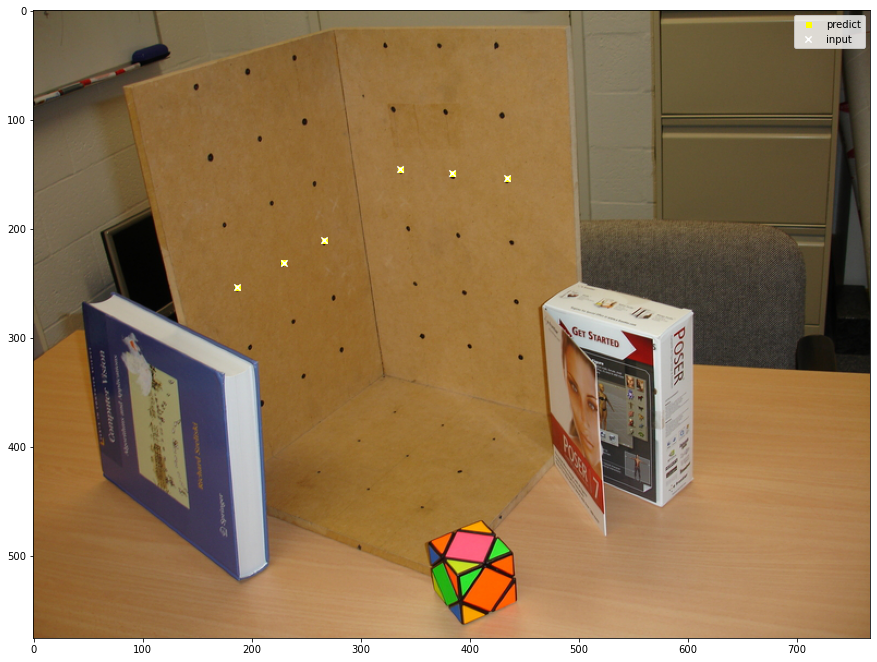

In [112]:
x,y=[],[]
for i in range(len(XYZ)):
    sb = originxyz[i].copy()
    sb = np.mat(sb).T

    ssb = C*sb
    ssb = ssb/ssb[2]
    x.append(ssb[0])
    y.append(ssb[1])
plt.figure(figsize=(15, 15))
plt.imshow(I)
x=x+center[0]
y=y+center[1]
plt.scatter(x,y,color='yellow',s=25,marker='s')
plt.scatter(inputuv[:,0],inputuv[:,1],color='white',s=40,marker='x')
plt.legend(['predict','input'])
# plt.savefig('dlt')

# 4

In [113]:
import vgg_KR_from_P as vgg

K, R, t = vgg.vgg_KR_from_P(C)
print()
print("matrix K:",K)
print()
print("matrix R:",R)
print()
print("matrix t:",t)

3 | [[-3.87778406e-01 -2.43086173e-02 -1.32596048e-03]
 [-7.73040110e-02  2.11534525e+00  1.08960567e-03]
 [ 1.90147011e-04 -8.74194839e-03 -2.05215037e-06]]

matrix K: [[0.9923956586982967 -44.38699170597921 array([[1.81502024]])]
 [0.0 -3.578577250269254 array([[-242.05424591]])]
 [0.0 0.0 array([[1.]])]]

matrix R: [[-0.018947647190450844 -0.00017742686978680799 -0.9998204614757852]
 [0.9995839634485439 0.0217465004649073 -0.01894702441096277]
 [array([[0.02174596]]) array([[-0.9997635]]) array([[-0.00023469]])]]

matrix t: [  0.07589764  21.03889279 -20.30200911]


e:\anaconda2021\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [115]:
K, R, t = vgg.vgg_KR_from_P(P11)
K

3 | [[-3.67798870e-01 -2.80763490e+00 -2.14419133e-03]
 [-4.73662296e-03 -1.37133675e+00  3.37355210e-04]
 [ 2.09996905e-04 -9.65549286e-03 -2.29526976e-06]]


array([[1.0050074877305202, -44.384262265073446, array([[289.81558992]])],
       [0.0, -3.5784592808440547, array([[141.94876276]])],
       [0.0, 0.0, array([[1.]])]], dtype=object)

In [116]:
C

array([[-3.87778406e-01, -2.43086173e-02, -1.32596048e-03,
         5.13938196e-01],
       [-7.73040110e-02,  2.11534525e+00,  1.08960567e-03,
        -4.44765336e+01],
       [ 1.90147011e-04, -8.74194839e-03, -2.05215037e-06,
         1.83864821e-01]])

In [117]:
C.shape[0]


3

# 5

In [43]:
import math
-180*math.atan2(-1*R[2,0], math.sqrt( R[2,1]**2+R[2,2]**2 ) )/math.pi

-26.182739995507493

# 6

array([[160.5, 167.5],
       [177.5, 149. ],
       [137. , 131.5],
       [171.5, 203. ],
       [197. , 128.5],
       [118. , 142. ]])

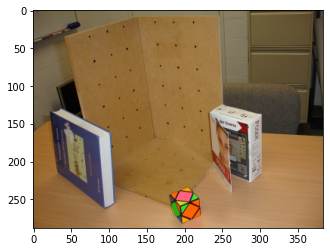

In [27]:
import cv2
size = (int(w*0.5), int(h*0.5))  
shrink = cv2.resize(im, size)
plt.imshow(shrink)
uv2 = inputuv.copy()
uv2 = uv2/2
uv2

In [7]:
# plt.savefig('shrink')

center = np.array(shrink[:,:,0].shape)/2
uv2 = [i-center for i in uv2]

h,w = shrink[:,:,0].shape
T_norm = np.array([[w+h,0,w/2],[0,w+h,h/2],[0,0,1]])
T_norm = np.linalg.inv(T_norm)
S_norm = np.zeros((4,4))
S_norm[-1,-1]=1

XYZ = np.array([[0,0,0],[7,7,0],[0,14,7],[14,0,14],[14,14,0],[0,14,14]])
XYZ_mean,now = [0,0,0],np.zeros((3,3))
for i in XYZ:
    XYZ_mean = XYZ_mean+i
XYZ_mean = XYZ_mean/len(XYZ)
for i in XYZ:
    mat = np.mat(i - XYZ_mean)
    now = now + mat.T*mat
val,vec = np.linalg.eig(now)
S_norm[:3,:3] = np.diag(1/val)
S_norm[:3,3] = (np.diag(-1/val))@XYZ_mean

uv2 = [np.append(i,1) for i in uv2]
XYZ = [np.append(i,1) for i in XYZ]

uv2 = [T_norm@i for i in uv2]
XYZ = [S_norm@i for i in XYZ]

C = calibrate(shrink,XYZ,uv2)

import vgg_KR_from_P as vgg
K, R, t = vgg.vgg_KR_from_P(C)
print()
print(K)
print()
print(R)
print()
print(t)

3 | [[-0.84963084  0.16056529  0.7030659 ]
 [-0.2176838   0.93650884 -0.54337279]
 [ 0.00132686  0.00121079  0.00241171]]

[[360.8630819   -2.26744137  84.33812166]
 [ -0.         363.63366798 -51.46335771]
 [ -0.          -0.           1.        ]]

[[ 0.88693    -0.05960165 -0.45804239]
 [ 0.13662497 -0.91341695  0.38340982]
 [-0.44123554 -0.40263769 -0.80199382]]

[62.77183476 48.22114397 72.23511016]


# Task-2 Two-View DLT based homography estimation

# 1

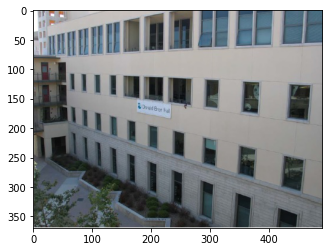

In [59]:
# vbase = [[270.52705627705626, 114.02380952380952], [256.51190476190476, 247.16774891774892], [152.3993506493506, 109.01839826839824], [158.40584415584414, 220.13852813852813], [233.48701298701297, 183.09848484848484], [174.42316017316017, 173.08766233766232]]
vbase = [[315.57575757575756, 116.025974025974], [232.4859307359307, 184.09956709956708], [310.57034632034635, 266.1883116883117], [129.3744588744588, 108.01731601731598], [174.42316017316017, 172.08658008658008], [129.3744588744588, 210.12770562770564]]
# vtrans = [[317.5779220779221, 146.05844155844153], [307.56709956709955, 250.17099567099567], [168.41666666666663, 146.05844155844153], [180.42965367965365, 250.17099567099567], [282.5400432900433, 203.12012987012986], [207.45887445887445, 203.12012987012986]]
vtrans = [[360.62445887445887, 148.06060606060606], [283.54112554112555, 203.12012987012986], [359.62337662337666, 249.16991341991343], [128.3733766233766, 148.06060606060606], [206.45779220779218, 203.12012987012986], [130.37554112554108, 250.17099567099567]]
inputr = np.array(vtrans)
inputl = np.array(vbase)

I = Image.open('left.jpg');
im = np.array(I).astype('uint8')
plt.imshow(im)

originu = [np.append(i,1) for i in vbase]

h,w = im[:,:,0].shape
T_norm = np.array([[w+h,0,w/2],[0,w+h,h/2],[0,0,1]])
T_norm = np.linalg.inv(T_norm)

ubase = [np.append(i,1) for i in vbase]
utrans = [np.append(i,1) for i in vtrans]
ubase = [T_norm@i for i in ubase]
utrans = [T_norm@i for i in utrans]

# 2

In [60]:
def homography(u2Trans, v2Trans, uBase, vBase):
    A = np.zeros((2*(len(vbase)),9))
    for i in range(A.shape[0]):
        if i%2==0:
            tmp = np.array(uBase[i//2])
            A[i,3:6] = (-1*tmp).copy()
            A[i,5]=-1
            
            tmp2 = u2Trans[i//2][1]*tmp
            A[i,6:9] = tmp2.copy()
            
            A[i,8] = u2Trans[i//2][1]
        else:
            A[i,:3] = tmp.copy()
            A[i,2] = 1
            
            tmp2=(-1*tmp).copy()
            tmp2 = u2Trans[i//2][0]*tmp2
            A[i,6:9] = tmp2.copy()
            A[i,8] = -1*u2Trans[i//2][0]

    u,s,v = np.linalg.svd(A)
    C = v[-1]
    C = C.reshape(3,3)
    C = np.linalg.inv(T_norm)@C@T_norm
    return C
C = homography(utrans, vtrans, ubase, vbase)
print('matrix H:',C)

matrix H: [[ 6.73535674e-01  2.59037318e-03 -4.95499274e+01]
 [ 1.15680640e-01  2.94161623e-01 -3.50906455e+00]
 [ 8.52294633e-04 -1.98196967e-05  1.85980584e-01]]


In [61]:
originu

[array([315.57575758, 116.02597403,   1.        ]),
 array([232.48593074, 184.0995671 ,   1.        ]),
 array([310.57034632, 266.18831169,   1.        ]),
 array([129.37445887, 108.01731602,   1.        ]),
 array([174.42316017, 172.08658009,   1.        ]),
 array([129.37445887, 210.12770563,   1.        ])]

In [62]:
sb = originu[0].copy()
print(sb)
sb = np.mat(sb).T
ssb = C*sb
ssb = ssb/ssb[2]
ssb

[315.57575758 116.02597403   1.        ]


matrix([[360.77352268],
        [148.30032981],
        [  1.        ]])

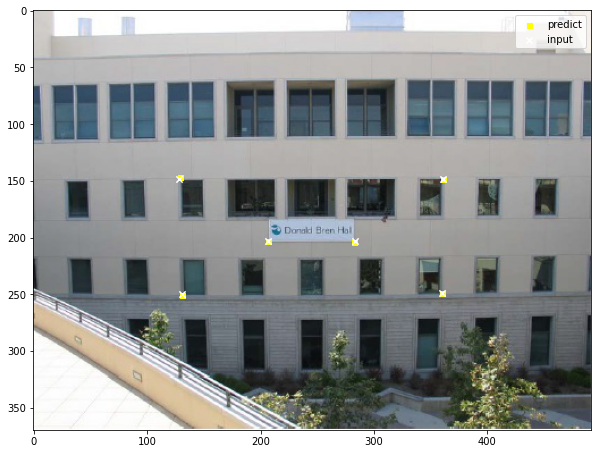

In [63]:
x,y=[],[]

for i in range(len(vbase)):
    sb = originu[i].copy()
    sb = np.mat(sb).T
    ssb = C*sb
#     print(ssb)
    ssb = ssb/ssb[2]
    x.append(ssb[0])
    y.append(ssb[1])
plt.figure(figsize=(10, 10))
hell = Image.open('right.jpg');
plt.imshow(hell)

plt.scatter(x,y,color='yellow',s=25,marker='s')
plt.scatter(inputr[:,0],inputr[:,1],color='white',s=40,marker='x')
plt.legend(['predict','input'])
# plt.savefig('afterdlt')

# 3

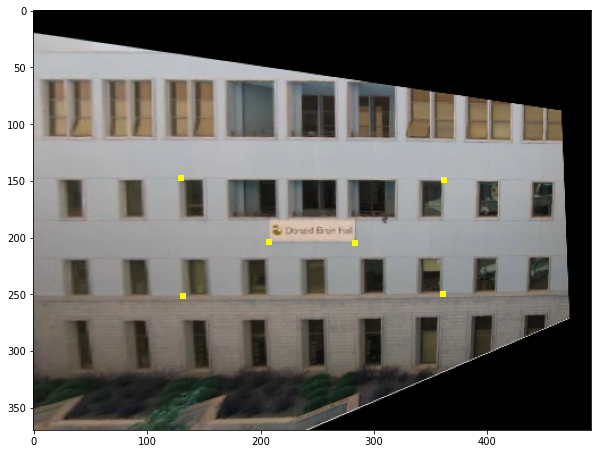

In [67]:
img = cv2.imread('left.jpg');
plt.figure(figsize=(10, 10))
nw = cv2.warpPerspective(img,C,(w,h))
plt.imshow(nw)
plt.scatter(x,y,color='yellow',s=25,marker='s')
plt.savefig('wraped2')

In [65]:
xx = np.array(x)
xx= [i[0,0] for i in xx]
yy = np.array(y)
yy= [i[0,0] for i in yy]
yy

tmp = inputr.copy()
tmp[:,0]-=xx
tmp[:,1]-=yy
tmp


array([[-0.1490638 , -0.23972375],
       [ 0.96383233, -0.67620952],
       [-0.32048717,  0.58496053],
       [-0.38406677,  1.06676467],
       [ 0.02690576, -0.03062922],
       [-0.17963236, -0.6790911 ]])

In [66]:
for i in tmp:
    print(np.linalg.norm(i))

0.2822897315796688
1.1773835682240874
0.6670013865970991
1.1337963387135694
0.04076848450723069
0.7024475138312357
